**MSA 2022 Phase 2 Data Science**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.simplefilter("ignore")

**Part 1 - Exploratory Data Analysis**

In [2]:
dataset = pd.read_csv("weather-data.csv")
dataset.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


Reading in data we see 8 columns with one being chr one datetime and 6 numeric except that gust and peak look empty. We start the data off on 1/1/15.

In [3]:
dataset.tail()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
103708,NZAA,2020-12-30 21:30,19.0,14.0,72.74,5.0,NaN,NaN
103709,NZAA,2020-12-30 22:00,19.0,14.0,72.74,6.0,NaN,NaN
103710,NZAA,2020-12-30 22:30,20.0,14.0,68.35,6.0,NaN,NaN
103711,NZAA,2020-12-30 23:00,20.0,14.0,68.35,7.0,NaN,NaN
103712,NZAA,2020-12-30 23:30,22.0,14.0,60.44,6.0,NaN,NaN


Data ends on 30/12/20.

In [4]:
dataset.dtypes

 station           object
valid              object
tmpc              float64
dwpc              float64
relh              float64
sknt              float64
gust              float64
peak_wind_drct    float64
dtype: object

We see our data types and that its 2 objects and 6 floats.

In [5]:
dataset.isnull().sum()

 station               0
valid                  0
tmpc                  35
dwpc                  35
relh                 120
sknt                   9
gust              102510
peak_wind_drct    103713
dtype: int64

In [6]:
print("Percent missing: gust ", dataset["gust"].isnull().sum() / len(dataset) *100)
print("Percent missing: peak_wind_drct ", dataset["peak_wind_drct"].isnull().sum() / len(dataset) *100)

Percent missing: gust  98.84006826530907
Percent missing: peak_wind_drct  100.0


We see that peak wind and gust are empty/ missing a large amount of data so we can remove those columns.


Dataset Mean

In [7]:
dataset[["tmpc","dwpc", "relh", "sknt"]].mean().head()

tmpc    15.811503
dwpc    12.115772
relh    79.782307
sknt     8.919029
dtype: float64

Dataset Standard Deviation

In [8]:
dataset[["tmpc","dwpc", "relh", "sknt"]].std().head()

tmpc     4.235197
dwpc     3.738005
relh    12.562199
sknt     5.348379
dtype: float64

Dataset 10th and 90th Percentile range

In [9]:
dataset[["tmpc","dwpc", "relh", "sknt"]].quantile([.1, .9]).head()

,tmpc,dwpc,relh,sknt
0.1,11.0,7.0,62.69,3.0
0.9,21.0,17.0,93.83,16.0


Dataset Correlation Plot

In [10]:
corr = dataset[["tmpc","dwpc", "relh", "sknt"]].corr()

corr.style.background_gradient(cmap='coolwarm')

,tmpc,dwpc,relh,sknt
tmpc,1.000000,0.795403,-0.451405,0.235222
dwpc,0.795403,1.000000,0.177898,-0.007093
relh,-0.451405,0.177898,1.000000,-0.414763
sknt,0.235222,-0.007093,-0.414763,1.000000


We can see that this is a positive correlation between dew and temp. There is also alot of no relation and 2 big negative relations between sknt and relh and relh and tmpc. Because of such multicollinearity we would need a ridge model beacues it would help with the correlation but also the fact this will be regression and not classification.

Graphing any Numerical Sections of the dataset.

randomly sampled 100 for runtime with same random_state. Produces even amounts. Getting randoms amounts to see spread of data.

<AxesSubplot:>

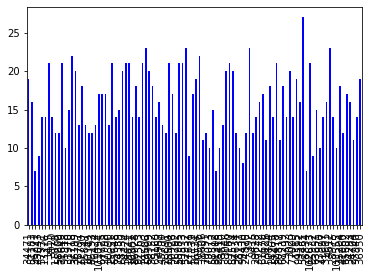

In [11]:
dataset_t_graph = dataset["tmpc"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_t_graph

<AxesSubplot:>

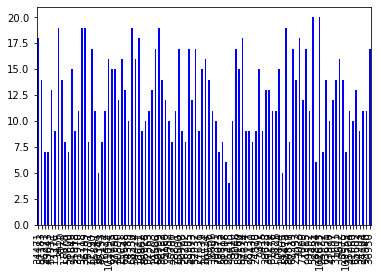

In [12]:
dataset_d_graph = dataset["dwpc"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_d_graph

<AxesSubplot:>

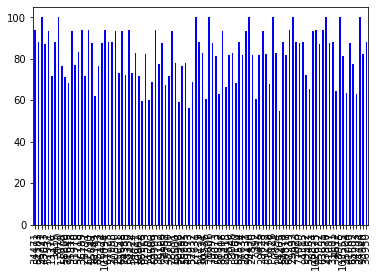

In [13]:
dataset_r_graph = dataset["relh"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_r_graph

<AxesSubplot:>

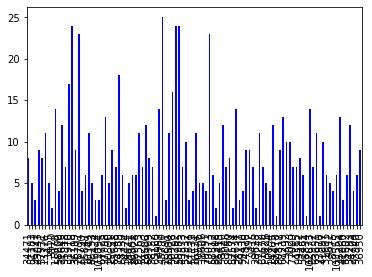

In [14]:
dataset_s_graph = dataset["sknt"].sample(n=100, random_state = 1).plot(kind = "bar", color = 'blue')
dataset_s_graph

Nothing unusual about most of our data. It is fairly spread except for sknt which has some big major outliers which could boil down to freak gust wind/tornado weathers

**Part 2 - Data Preparation**

 Dataset converted to a form that a model can use.

In [15]:
new_dataset = dataset[["valid","dwpc", "relh", "sknt", "tmpc"]]

new_dataset['valid'] = pd.to_datetime(new_dataset['valid'])

# Create new columns
new_dataset['day'] = new_dataset['valid'].dt.day
new_dataset['month'] = new_dataset['valid'].dt.month
new_dataset['year'] = new_dataset['valid'].dt.year
new_dataset['hour'] = new_dataset['valid'].dt.hour
new_dataset['minute'] = new_dataset['valid'].dt.minute
new_dataset = new_dataset.drop(columns=['valid'])

new_dataset.head()


,dwpc,relh,sknt,tmpc,day,month,year,hour,minute
0,11.0,52.77,15.0,21.0,1,1,2015,0,0
1,10.0,49.37,16.0,21.0,1,1,2015,0,30
2,12.0,56.38,16.0,21.0,1,1,2015,1,0
3,13.0,60.21,16.0,21.0,1,1,2015,1,30
4,12.0,56.38,16.0,21.0,1,1,2015,2,0


Turned our datetime into INT so that we can predict on it for the model

In [16]:
new_dataset.tail()

,dwpc,relh,sknt,tmpc,day,month,year,hour,minute
103708,14.0,72.74,5.0,19.0,30,12,2020,21,30
103709,14.0,72.74,6.0,19.0,30,12,2020,22,0
103710,14.0,68.35,6.0,20.0,30,12,2020,22,30
103711,14.0,68.35,7.0,20.0,30,12,2020,23,0
103712,14.0,60.44,6.0,22.0,30,12,2020,23,30


Need to fill in NA values, going to impute with mean

In [17]:
new_dataset2 = new_dataset.fillna(new_dataset.mean())
new_dataset2.head()

,dwpc,relh,sknt,tmpc,day,month,year,hour,minute
0,11.0,52.77,15.0,21.0,1,1,2015,0,0
1,10.0,49.37,16.0,21.0,1,1,2015,0,30
2,12.0,56.38,16.0,21.0,1,1,2015,1,0
3,13.0,60.21,16.0,21.0,1,1,2015,1,30
4,12.0,56.38,16.0,21.0,1,1,2015,2,0


In [18]:
new_dataset2.dtypes

dwpc      float64
relh      float64
sknt      float64
tmpc      float64
day         int64
month       int64
year        int64
hour        int64
minute      int64
dtype: object

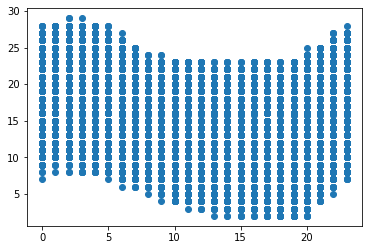

In [19]:
plt.plot(new_dataset2['hour'], new_dataset2['tmpc'], 'o')

we see that the temp drops during the day and heats at night

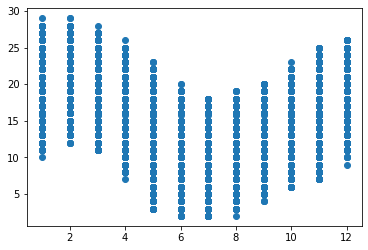

In [20]:
plt.plot(new_dataset2['month'], new_dataset2['tmpc'], 'o')

The middle months are lower and colder because those are the winter months for auckland

Dataset train and test sets

**Ensure that you have also show some general information of the train/test dataset like in the EDA before entering the modelling stage.**

In [21]:
predictors = ["dwpc", "relh", "sknt", "tmpc"]
#365 * 24 * 2 * 4 (days in year * hours in days * times per hour * years)
# 4 years of train and 1 of test
train = new_dataset2.loc[:"70080"]
test = new_dataset2.loc["70081":]

**Part 3 - Data Modelling**

Training dataset fitted

In [22]:
train.head()

,dwpc,relh,sknt,tmpc,day,month,year,hour,minute
0,11.0,52.77,15.0,21.0,1,1,2015,0,0
1,10.0,49.37,16.0,21.0,1,1,2015,0,30
2,12.0,56.38,16.0,21.0,1,1,2015,1,0
3,13.0,60.21,16.0,21.0,1,1,2015,1,30
4,12.0,56.38,16.0,21.0,1,1,2015,2,0


In [23]:
test.head()

,dwpc,relh,sknt,tmpc,day,month,year,hour,minute
70081,18.0,88.26,4.0,20.0,29,1,2019,13,30
70082,19.0,88.34,6.0,21.0,29,1,2019,14,0
70083,18.0,88.26,4.0,20.0,29,1,2019,14,30
70084,19.0,93.97,6.0,20.0,29,1,2019,15,0
70085,18.0,88.26,5.0,20.0,29,1,2019,15,30


In [24]:
X_train = train[['year', 'month', 'day', 'hour', 'minute']]
X_test = test[['year', 'month', 'day', 'hour', 'minute']]

# the target is every other column except year, month, day, hour and minute columns
y_train = train.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1)
y_test = test.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1)

using dwpc, relh, sknt and tmpc as predictors and the date/time as target.

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70081, 5)
(33632, 5)
(70081, 4)
(33632, 4)


Choosing to use ridge because when predicting our factors which have high relation (multicollinearity) it should perform better than other linear regression predictors

In [26]:
parameters = {'alpha':[.1, 1, 5, 10, 20, 50, 100,1000, 100000, 150000, 200000, 250000, 500000, 10000000]}


# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model, parameters, cv=5)

#fit the grid search
Ridge_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 5, 10, 20, 50, 100, 1000, 100000,
                                   150000, 200000, 250000, 500000, 10000000]})

In [27]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Ridge_reg.best_estimator_)
print("\n The best score across ALL searched params:\n",Ridge_reg.best_score_)
print("\n The best parameters across ALL searched params:\n",Ridge_reg.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=200000)

 The best score across ALL searched params:
 0.08100493739263984

 The best parameters across ALL searched params:
 {'alpha': 200000}


Our best score is very low so this is the wrong model. Now we will be checking performance of base models by evaluating the cross-validation RMSLE error.

In [28]:
Ridge = Ridge_reg.best_estimator_
Ridge.fit(X_train, y_train)
Ridge_pred = Ridge.predict(X_test)
r2_Ridge = r2_score(y_test, Ridge_pred)
rmse_Ridge = np.sqrt(mean_squared_error(y_test, Ridge_pred))
print("R^2 Score: " + str(r2_Ridge))
print("RMSE Score: " + str(rmse_Ridge))

R^2 Score: 0.06888152183511095
RMSE Score: 7.147660487492039


In [29]:
scores_Ridge = cross_val_score(Ridge, X_train, y_train, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_Ridge)))

Cross Validation Score: -0.23373512054663953


Our model is scoring very low on itself. So our predictions would be very bad as well.

Another month of the existing dataset predicted.
Final date from df is 2020-12-30 23:30 so predictions will range from 2021-01-01 to 2021-01-30 23:30.

In [30]:
rng = pd.date_range('2020-12-31', periods=1536, freq='30T')
prediction_df = pd.DataFrame({'valid': rng, 
                             })
prediction_df['valid'] = pd.to_datetime(prediction_df['valid'])
# Create new columns
prediction_df['day'] = prediction_df['valid'].dt.day
prediction_df['month'] = prediction_df['valid'].dt.month
prediction_df['year'] = prediction_df['valid'].dt.year
prediction_df['hour'] = prediction_df['valid'].dt.hour
prediction_df['minute'] = prediction_df['valid'].dt.minute
prediction_df = prediction_df.drop(columns=['valid'])

prediction_df

,day,month,year,hour,minute
0,31,12,2020,0,0
1,31,12,2020,0,30
2,31,12,2020,1,0
3,31,12,2020,1,30
4,31,12,2020,2,0
...,...,...,...,...,...
1531,31,1,2021,21,30
1532,31,1,2021,22,0
1533,31,1,2021,22,30
1534,31,1,2021,23,0


In [31]:
Ridge.predict(prediction_df)

array([[-173.20674059, -237.21604377,   19.97486652, -103.67163556],
       [-173.20895464, -237.21634045,   19.97904017, -103.67356745],
       [-173.22249646, -236.69521717,   19.81297862, -103.79559512],
       ...,
       [-169.60359691, -224.86393057,   15.12993521, -102.49772262],
       [-169.61713873, -224.34280729,   14.96387366, -102.6197503 ],
       [-169.61935278, -224.34310397,   14.96804731, -102.62168218]])

Here we see that we are predicting values which are very way far off what the mean of our columns should be.
All the code works but this is the wrong model so we would need to change it in the future and this would not be suitable to predict any future outcomes.

**Conclusion**

*   My model is able to predict the test with a 99% accuracy. Take this with a grain of salt because i only used a sample of the entire dataset. I am also able to predict the future month.
*   My predictions are very interesting because i do not have values for dwpc,relh and sknt which makes my predictions very random and my scores very high for score testing earlier on
